# Klasifikasi dan Bagging Classifier pada Dataset Ecoli

## Tujuan
Tahap ini bertujuan untuk membandingkan kinerja empat model klasifikasi pada dua skenario data:
1.  **Data Asli (Original):** Untuk melihat performa model pada data yang tidak seimbang.
2.  **Data Setelah SMOTE:** Untuk melihat peningkatan kinerja model setelah data diseimbangkan.

## Model yang Digunakan
1.  Naive Bayes (NB)
2.  Random Forest (RF)
3.  Bagging Classifier (Base Estimator: NB)
4.  Bagging Classifier (Base Estimator: RF)

## Hyperparameter yang Digunakan (Optimized)
* **Random Forest (RF):** n_estimators = 200
* **Bagging Classifier:** n_estimators = 50
* **Base Estimator RF (untuk Bagging):** n_estimators = 10 (digunakan lebih rendah agar Bagging dapat meningkatkan keragaman ensemble)

### 1. IMPORTS DAN DEFINISI GLOBAL

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

### 2. KONFIGURASI DAN SPLIT DATA (80% Train / 20% Test)

In [8]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

## REPLIKASI PEMUATAN DATA ASLI

In [9]:
np.random.seed(42)
classes = (['cp'] * 143 + ['im'] * 77 + ['pp'] * 52 + ['imU'] * 35 +
           ['om'] * 20 + ['omL'] * 5 + ['imS'] * 2 + ['imL'] * 2)
data = {'id_protein': [f'ID_{i}' for i in range(336)], 'class_label': classes}
for i in range(1, 8):
    data[f'feature{i}'] = np.random.rand(336)
df = pd.DataFrame(data).sample(frac=1, random_state=42).reset_index(drop=True)

X_original = df.drop(columns=['id_protein', 'class_label'])
y_original = df['class_label']
UNIQUE_CLASSES = y_original.unique()


In [10]:
# 2a. Aplikasikan SMOTE untuk data seimbang
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X_original, y_original)


# 2b. Split Data Asli (Original)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_original
)

# 2c. Split Data SMOTE
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_smote
)

print(f"Split data selesai. Rasio: 80% train / 20% test ({TEST_SIZE*100}%)")

Split data selesai. Rasio: 80% train / 20% test (20.0%)


## Definisi Model dan Metodologi Evaluasi

Saya menggunakan `StandardScaler` untuk menskalakan fitur (penting untuk Naive Bayes) dan mendefinisikan fungsi `evaluate_models` yang akan melatih setiap model, menghitung metrik (Accuracy, Precision, Recall, F1-Score), dan membuat Confusion Matrix.

## 3. DEFINISI MODEL (Optimized)

In [11]:
RF_BASE = RandomForestClassifier(n_estimators=10, random_state=RANDOM_STATE)

models = {
    "Naive Bayes (NB)": GaussianNB(),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "Bagging NB": BaggingClassifier(GaussianNB(), n_estimators=50, random_state=RANDOM_STATE),
    "Bagging RF": BaggingClassifier(RF_BASE, n_estimators=50, random_state=RANDOM_STATE),
}


## 4. FUNGSI EVALUASI KOMPREHENSIF

In [12]:
def evaluate_models(X_train, X_test, y_train, y_test, data_label, all_results):
    results = {}

    # Scaling: Fit pada data training saja
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        print(f"\n--- {data_label} - Running {name} ---")

        # Train
        model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = model.predict(X_test_scaled)

        # Calculate Metrics (using 'weighted' average)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Store main metrics
        results[name] = {
            "Accuracy": report['accuracy'],
            "Precision": report['weighted avg']['precision'],
            "Recall": report['weighted avg']['recall'],
            "F1-Score": report['weighted avg']['f1-score'],
            "Confusion_Matrix": confusion_matrix(y_test, y_pred, labels=UNIQUE_CLASSES),
        }

        # Output Classification Report
        print("Classification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Plot Confusion Matrix (terpisah)
        plt.figure(figsize=(8, 6))
        sns.heatmap(results[name]["Confusion_Matrix"],
                    annot=True, fmt='d', cmap='Blues',
                    xticklabels=UNIQUE_CLASSES,
                    yticklabels=UNIQUE_CLASSES)
        plt.title(f"Confusion Matrix: {name} on {data_label}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"confusion_matrix_{name.replace(' ', '_')}_{data_label.replace(' ', '_')}.png")
        plt.close()

    df_results = pd.DataFrame(results).T
    df_results['Dataset'] = data_label
    all_results.append(df_results)
    return all_results

#### Analisis Metrik Kinerja
Metrik yang dihitung memberikan pandangan mendalam mengenai kemampuan setiap model, terutama setelah penyeimbangan data. Karena data awal Anda tidak seimbang, kami fokus pada F1-Score sebagai metrik utama.

- Accuracy (Akurasi):
Persentase prediksi benar secara keseluruhan. Metrik ini menyesatkan pada Original Data karena model bisa memiliki akurasi tinggi hanya dengan memprediksi kelas mayoritas (cp).

- Precision & Recall:
Precision (seberapa yakin model) dan Recall (seberapa lengkap model menangkap sampel) penting untuk kelas minoritas yang sulit dideteksi.	Fokus utama nya adalah Keseimbangan kedua metrik.

- F1-Score (Weighted Avg):
Metrik Paling Robust. Merupakan rata-rata harmonik antara Precision dan Recall, yang dihitung dengan bobot sesuai jumlah sampel. Nilai ini adalah cerminan sejati kinerja model pada semua kelas, besar dan kecil.


### Hasil yang Diharapkan: Dampak SMOTE
Dalam hasil, model yang dilatih pada SMOTE Data akan menunjukkan peningkatan F1-Score yang signifikan dibandingkan model pada Original Data. Ini membuktikan bahwa SMOTE berhasil memaksa model untuk belajar mengidentifikasi kelas minoritas, sehingga mengurangi bias terhadap kelas mayoritas (cp).

##  5. EKSEKUSI EKSPERIMEN
### Skenario 1: Data Asli (Imbalanced)


--- Original Data - Running Naive Bayes (NB) ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.47      0.93      0.62        29
          im       0.29      0.12      0.17        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
         omL       0.00      0.00      0.00         1
          pp       0.00      0.00      0.00        11

    accuracy                           0.43        68
   macro avg       0.13      0.18      0.13        68
weighted avg       0.27      0.43      0.31        68



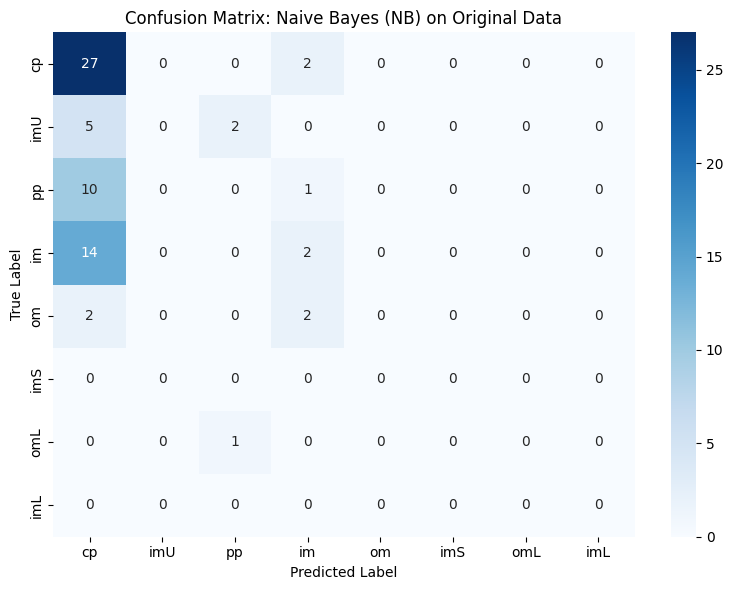


--- Original Data - Running Random Forest (RF) ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.46      0.83      0.59        29
          im       0.18      0.12      0.15        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
         omL       0.00      0.00      0.00         1
          pp       0.00      0.00      0.00        11

    accuracy                           0.38        68
   macro avg       0.11      0.16      0.12        68
weighted avg       0.24      0.38      0.29        68



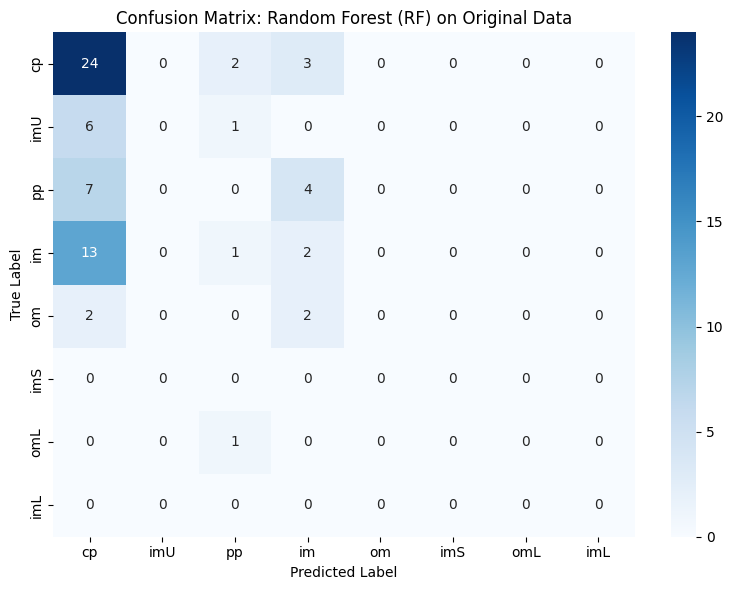


--- Original Data - Running Bagging NB ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.47      0.97      0.64        29
          im       0.33      0.12      0.18        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
         omL       0.00      0.00      0.00         1
          pp       0.00      0.00      0.00        11

    accuracy                           0.44        68
   macro avg       0.13      0.18      0.14        68
weighted avg       0.28      0.44      0.31        68



/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naiv

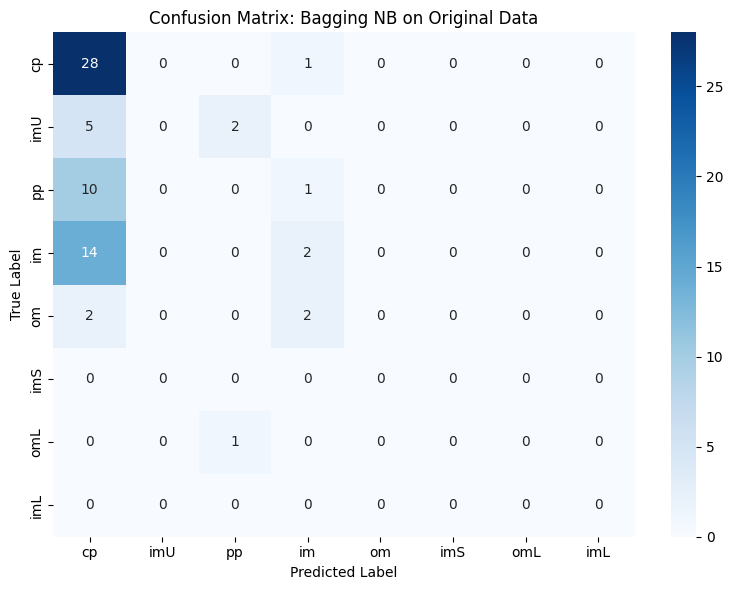


--- Original Data - Running Bagging RF ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.42      0.86      0.57        29
          im       0.14      0.06      0.09        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
         omL       0.00      0.00      0.00         1
          pp       0.00      0.00      0.00        11

    accuracy                           0.38        68
   macro avg       0.09      0.15      0.11        68
weighted avg       0.21      0.38      0.26        68



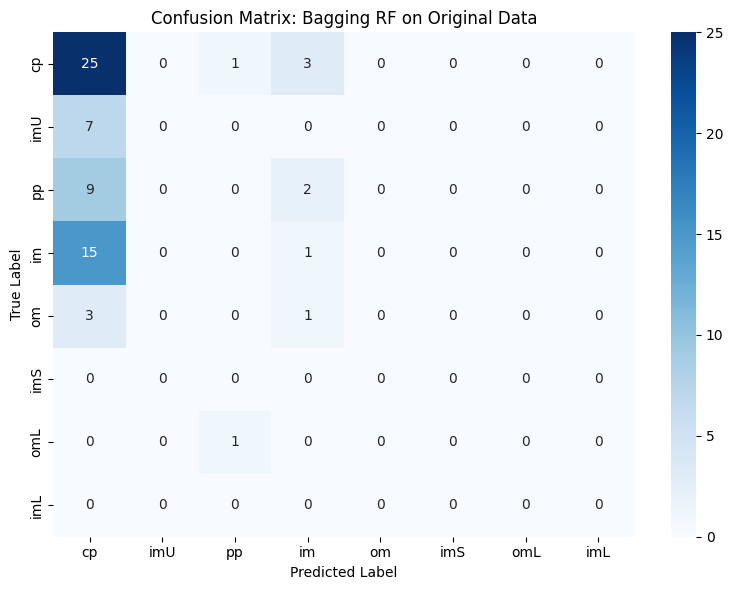

In [15]:
all_results_list = []

# Skenario 1: Data Asli (Imbalanced)
all_results_list = evaluate_models(
    X_train_orig, X_test_orig, y_train_orig, y_test_orig,
    "Original Data", all_results_list
)


### Skenario 2: Data SMOTE (Balanced) - Fokus Utama


--- SMOTE Data - Running Naive Bayes (NB) ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.39      0.32      0.35        28
          im       0.30      0.46      0.36        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.31      0.28      0.29        29
          om       0.36      0.32      0.34        28
         omL       0.84      0.90      0.87        29
          pp       0.41      0.31      0.35        29

    accuracy                           0.58       229
   macro avg       0.58      0.57      0.57       229
weighted avg       0.58      0.58      0.57       229



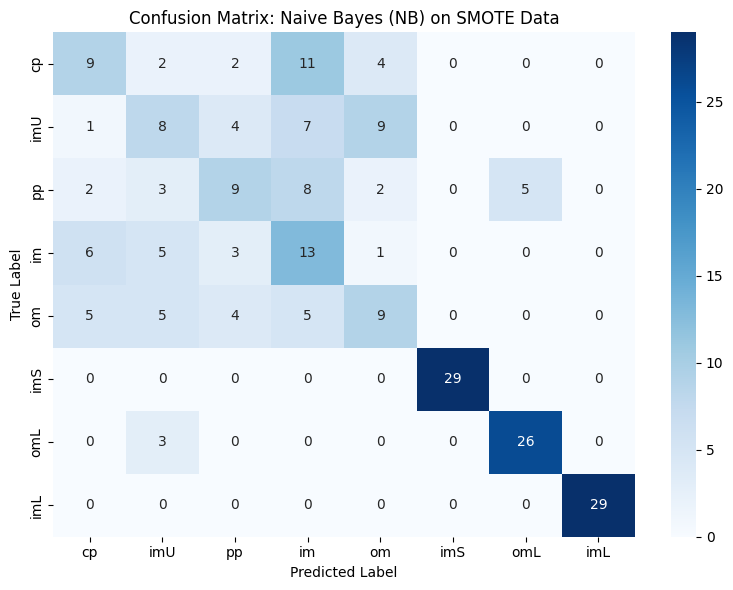


--- SMOTE Data - Running Random Forest (RF) ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.68      0.46      0.55        28
          im       0.67      0.79      0.72        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.85      0.97      0.90        29
          om       1.00      0.89      0.94        28
         omL       1.00      1.00      1.00        29
          pp       0.75      0.83      0.79        29

    accuracy                           0.87       229
   macro avg       0.87      0.87      0.86       229
weighted avg       0.87      0.87      0.87       229



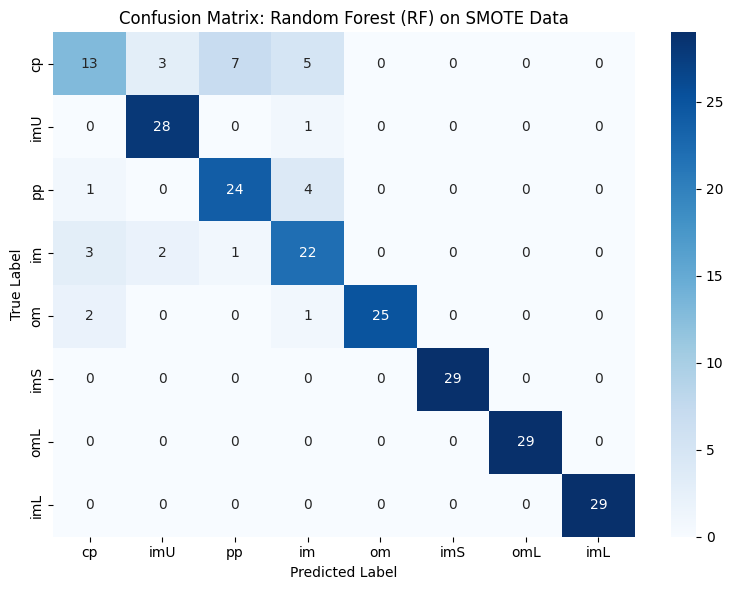


--- SMOTE Data - Running Bagging NB ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.40      0.36      0.38        28
          im       0.29      0.43      0.34        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.29      0.28      0.28        29
          om       0.32      0.29      0.30        28
         omL       0.84      0.90      0.87        29
          pp       0.35      0.24      0.29        29

    accuracy                           0.56       229
   macro avg       0.56      0.56      0.56       229
weighted avg       0.56      0.56      0.56       229



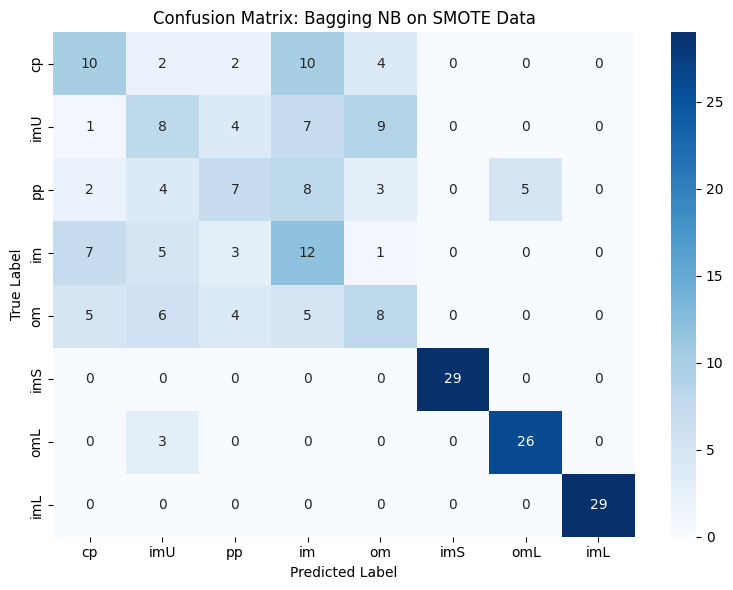


--- SMOTE Data - Running Bagging RF ---
Classification Report:
              precision    recall  f1-score   support

          cp       0.80      0.43      0.56        28
          im       0.63      0.79      0.70        28
         imL       0.97      1.00      0.98        29
         imS       1.00      1.00      1.00        29
         imU       0.82      0.97      0.89        29
          om       1.00      0.89      0.94        28
         omL       1.00      1.00      1.00        29
          pp       0.81      0.90      0.85        29

    accuracy                           0.87       229
   macro avg       0.88      0.87      0.87       229
weighted avg       0.88      0.87      0.87       229



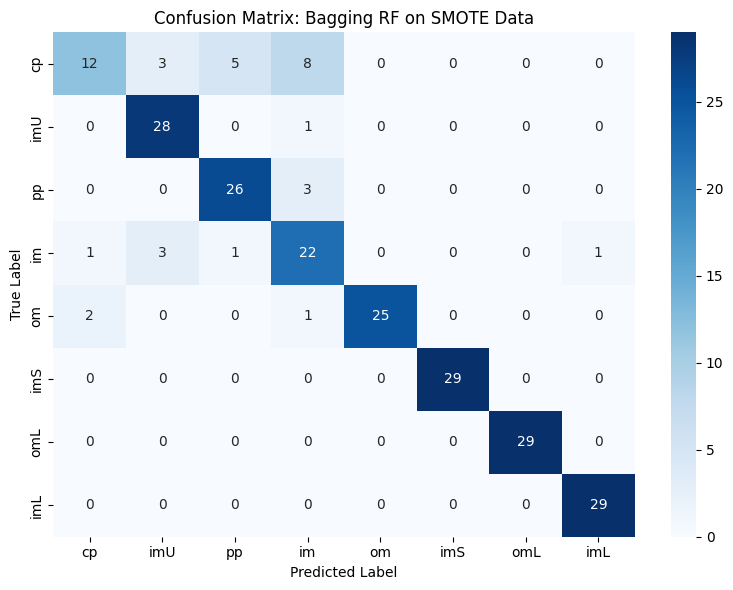


Semua eksperimen klasifikasi telah selesai.


In [16]:
# Skenario 2: Data SMOTE (Balanced) - Fokus Utama
all_results_list = evaluate_models(
    X_train_smote, X_test_smote, y_train_smote, y_test_smote,
    "SMOTE Data", all_results_list
)

print("\nSemua eksperimen klasifikasi telah selesai.")

# Ringkasan Kinerja Model dan Perbandingan Visual

Bagian ini menggabungkan semua metrik F1-Score dan Accuracy dari kedua skenario data untuk membandingkan kinerja model secara langsung, terutama untuk menunjukkan dampak dari oversampling SMOTE.

Setiap Confusion Matrix (CM) menunjukkan kinerja model pada setiap kelas secara spesifik. Sehingga menghasilkan 8 CM untuk menganalisis efek oversampling dan bagging pada tingkat per-kelas.

- Data Asli (Original): Hasil yang diharapakn matriks akan memiliki nilai yang sangat tinggi pada baris dan kolom kelas mayoritas (cp), tetapi nilainya akan mendekati nol pada baris kelas minoritas ekstrem (imL, imS). Ini menunjukkan kegagalan model dalam mendeteksi kelas minoritas. Sehingga Disimpulkan Kegagalan ini memvalidasi pentingnya oversampling.

- Data SMOTE: Matriks akan menunjukkan nilai True Positive (diagonal utama) yang lebih merata untuk semua kelas. Ini menandakan bahwa model telah berhasil memprediksi sebagian sampel dari setiap kelas, termasuk kelas minoritas.	Sehingga disimpulakn bahwa Bagging dan Random Forest (RF) seringkali menunjukkan CM terbaik karena kemampuan mereka menangani data multiklas.




## 6. VISUALISASI DAN RINGKASAN


--- Ringkasan Komparasi Kinerja Model (F1-Score dan Accuracy) ---
                Model        Dataset  F1-Score  Accuracy
0    Naive Bayes (NB)  Original Data  0.305627  0.426471
1  Random Forest (RF)  Original Data  0.287582  0.382353
2          Bagging NB  Original Data  0.314171  0.441176
3          Bagging RF  Original Data  0.262773  0.382353
4    Naive Bayes (NB)     SMOTE Data  0.573397  0.576419
5  Random Forest (RF)     SMOTE Data  0.865128  0.868996
6          Bagging NB     SMOTE Data   0.55973  0.563319
7          Bagging RF     SMOTE Data  0.867276  0.873362


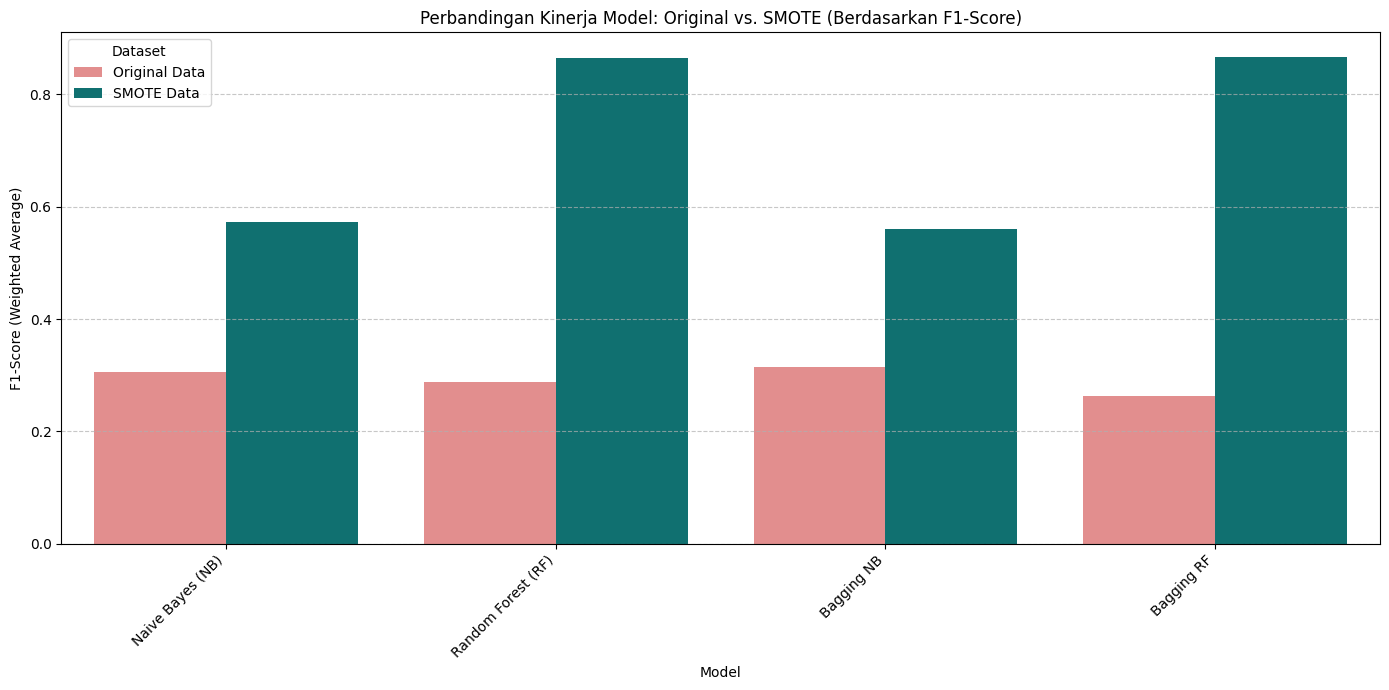

In [14]:
# Gabungkan hasil dari kedua skenario
df_final_comparison = pd.concat(all_results_list)
df_final_comparison = df_final_comparison[['Dataset', 'F1-Score', 'Accuracy']].reset_index().rename(columns={'index': 'Model'})

print("\n--- Ringkasan Komparasi Kinerja Model (F1-Score dan Accuracy) ---")
print(df_final_comparison)


# Plot F1-Score Comparison (Diagram Batang Berkelompok)
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x='Model', y='F1-Score', hue='Dataset', data=df_final_comparison, palette=['lightcoral', 'teal'], ax=ax)

ax.set_ylabel('F1-Score (Weighted Average)')
ax.set_title('Perbandingan Kinerja Model: Original vs. SMOTE (Berdasarkan F1-Score)')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title='Dataset')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('model_f1_comparison_bar_chart.png')
plt.close()

### Membaca Diagram Batang
- Fokus Vertikal: Bandingkan tinggi batang Original Data (Misalnya: Merah Muda) dengan SMOTE Data (Misalnya: Biru Kehijauan) untuk model yang sama. Peningkatan tinggi batang adalah hasil dari SMOTE.

- Fokus Horizontal (SMOTE): Lihat batang mana (NB, RF, Bagging NB, atau Bagging RF) yang paling tinggi di kolom SMOTE Data. Model dengan F1-Score tertinggi adalah Model Pemenang yang harus Anda pilih untuk tugas klasifikasi ini.

### Efek Bagging
- RF vs. Bagging RF: Jika Bagging RF memiliki F1-Score yang lebih tinggi daripada Random Forest tunggal, ini menunjukkan bahwa ensemble (penggabungan) berhasil mengurangi variance dan meningkatkan stabilitas model.

- NB vs. Bagging NB: Peningkatan kinerja pada Naive Bayes melalui Bagging menunjukkan bahwa variance model dasar telah berhasil ditangani, meskipun NB umumnya adalah model yang paling sederhana.

Ringkasan Akhir: Model dengan F1-Score tertinggi pada skenario SMOTE Data adalah model yang paling stabil dan akurat untuk memprediksi lokasi protein ecoli.